In [2]:
import torch
from torch import nn #neural network
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_circles
import pandas as pd

In [15]:
# Making 1000 samples
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

len(X), len(y)

(1000, 1000, (1000, 2))

In [9]:
print(X[:5,0])

[ 0.75424625 -0.75615888 -0.81539193 -0.39373073  0.44220765]


In [11]:
circles = pd.DataFrame({"X1":X[:,0],"X2":X[:,1], "label":y})


circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


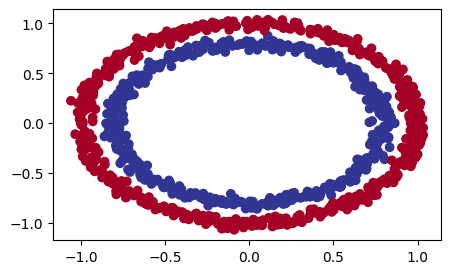

In [19]:
plt.figure(figsize=(5,3))
plt.scatter(x=X[:,0], y = X[:,1], c=y, cmap=plt.cm.RdYlBu);